In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pathlib
import pandas as pd
import pickle as pkl

2024-07-16 16:29:11.427671: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 16:29:11.439557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 16:29:11.453381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 16:29:11.457887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 16:29:11.467605: I tensorflow/core/platform/cpu_feature_guar

In [4]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [5]:
def load_data(path):
    df = pd.read_csv(path, sep='\t', header=None)
    return df

In [6]:
df_data = load_data(path_to_file)
df_data.columns = ['english', 'spanish']

In [7]:
print(f'English: {df_data.iloc[-1, 0]}')
print(f'Spanish: {df_data.iloc[-1, 1]}') 

English: If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.
Spanish: Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [8]:
def preprocessing(data):
    data = data.str.normalize('NFD')
    data = data.str.encode('ascii', 'ignore').str.decode('utf-8')
    data = data.str.lower()
    data = data.str.replace(r"([^ a-z.?!¡,¿])", "", regex=True)
    data = data.str.replace(r"([?.!¡,¿])", r" \1 ", regex=True)
    data = data.str.replace(r'[" "]+', " ")
    data = data.str.strip()
    data = '<START> ' + data + ' <END>'
    return data

In [9]:
df_data['english'] = preprocessing(df_data['english'])
df_data['spanish'] = preprocessing(df_data['spanish'])

In [10]:
print(f'English: {df_data.iloc[-1, 0]}')
print(f'Spanish: {df_data.iloc[-1, 1]}')

English: <START> if you want to sound like a native speaker ,  you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <END>
Spanish: <START> si quieres sonar como un hablante nativo ,  debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <END>


In [11]:
x_train, x_test, y_train, y_test = train_test_split(df_data['english'], df_data['spanish'], test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((95171,), (23793,), (95171,), (23793,))

In [12]:
tokenizer_x = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
tokenizer_x.fit_on_texts(x_train)
x_train = tokenizer_x.texts_to_sequences(x_train)
x_test = tokenizer_x.texts_to_sequences(x_test)

tokenizer_y = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
tokenizer_y.fit_on_texts(y_train)
y_train = tokenizer_y.texts_to_sequences(y_train)
y_test = tokenizer_y.texts_to_sequences(y_test)

max_length_x = max([len(sentence) for sentence in x_train])
max_length_y = max([len(sentence) for sentence in y_train])
max_length = max(max_length_x, max_length_y)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=max_length, truncating='post')
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen=max_length, truncating='post')
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding='post', maxlen=max_length, truncating='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test, padding='post', maxlen=max_length, truncating='post')

In [13]:
import os

# Set the environment variable within your Python script
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Your TensorFlow/Keras model code follows

In [14]:
# Define the encoder
encoder_inputs = tf.keras.layers.Input(shape=(None,))

encoder_embedding_layer = tf.keras.layers.Embedding(input_dim=len(tokenizer_x.word_index)+1, output_dim=256)
encoder_embedding = encoder_embedding_layer(encoder_inputs)

encoder_outputs, state_h_enc, state_c_enc = tf.keras.layers.LSTM(256, return_sequences=True, return_state=True)(encoder_embedding)
encoder_states = [state_h_enc, state_c_enc]

# Define the decoder
decoder_inputs = tf.keras.layers.Input(shape=(None,))
decoder_embedding_layer = tf.keras.layers.Embedding(input_dim=len(tokenizer_y.word_index)+1, output_dim=256)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention layer
attention_layer = tf.keras.layers.Attention()
# Both inputs to the attention layer are now 3D tensors
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate attention input and decoder LSTM output
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention_outputs])

# Dense layer
decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(tokenizer_y.word_index)+1, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Encoder Model untuk Inference
encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

# Decoder Model untuk Inference
# Adjusted part for the inference model
decoder_state_input_h = tf.keras.layers.Input(shape=(256,))
decoder_state_input_c = tf.keras.layers.Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Use the decoder_embedding_layer for the inference decoder inputs
decoder_embedding_inf = decoder_embedding_layer(decoder_inputs)  # Corrected line
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]

attention_outputs_inf = attention_layer([decoder_outputs_inf, encoder_outputs])
decoder_concat_input_inf = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs_inf, attention_outputs_inf])
decoder_outputs_inf = decoder_dense(decoder_concat_input_inf)

decoder_model = tf.keras.models.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs_inf] + decoder_states_inf)

I0000 00:00:1721118559.484610   16137 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721118559.955325   16137 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721118559.957335   16137 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721118559.969237   16137 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  3,170,816 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  5,807,616 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, None,     │    525,312 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    525,312 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 256) │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 512) │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │ 11,637,918 │ concatenate[0][0] │
│ (TimeDistributed)   │ 22686)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,666,974 (82.65 MB)

 Trainable params: 21,666,974 (82.65 MB)

 Non-trainable params: 0 (0.00 B)

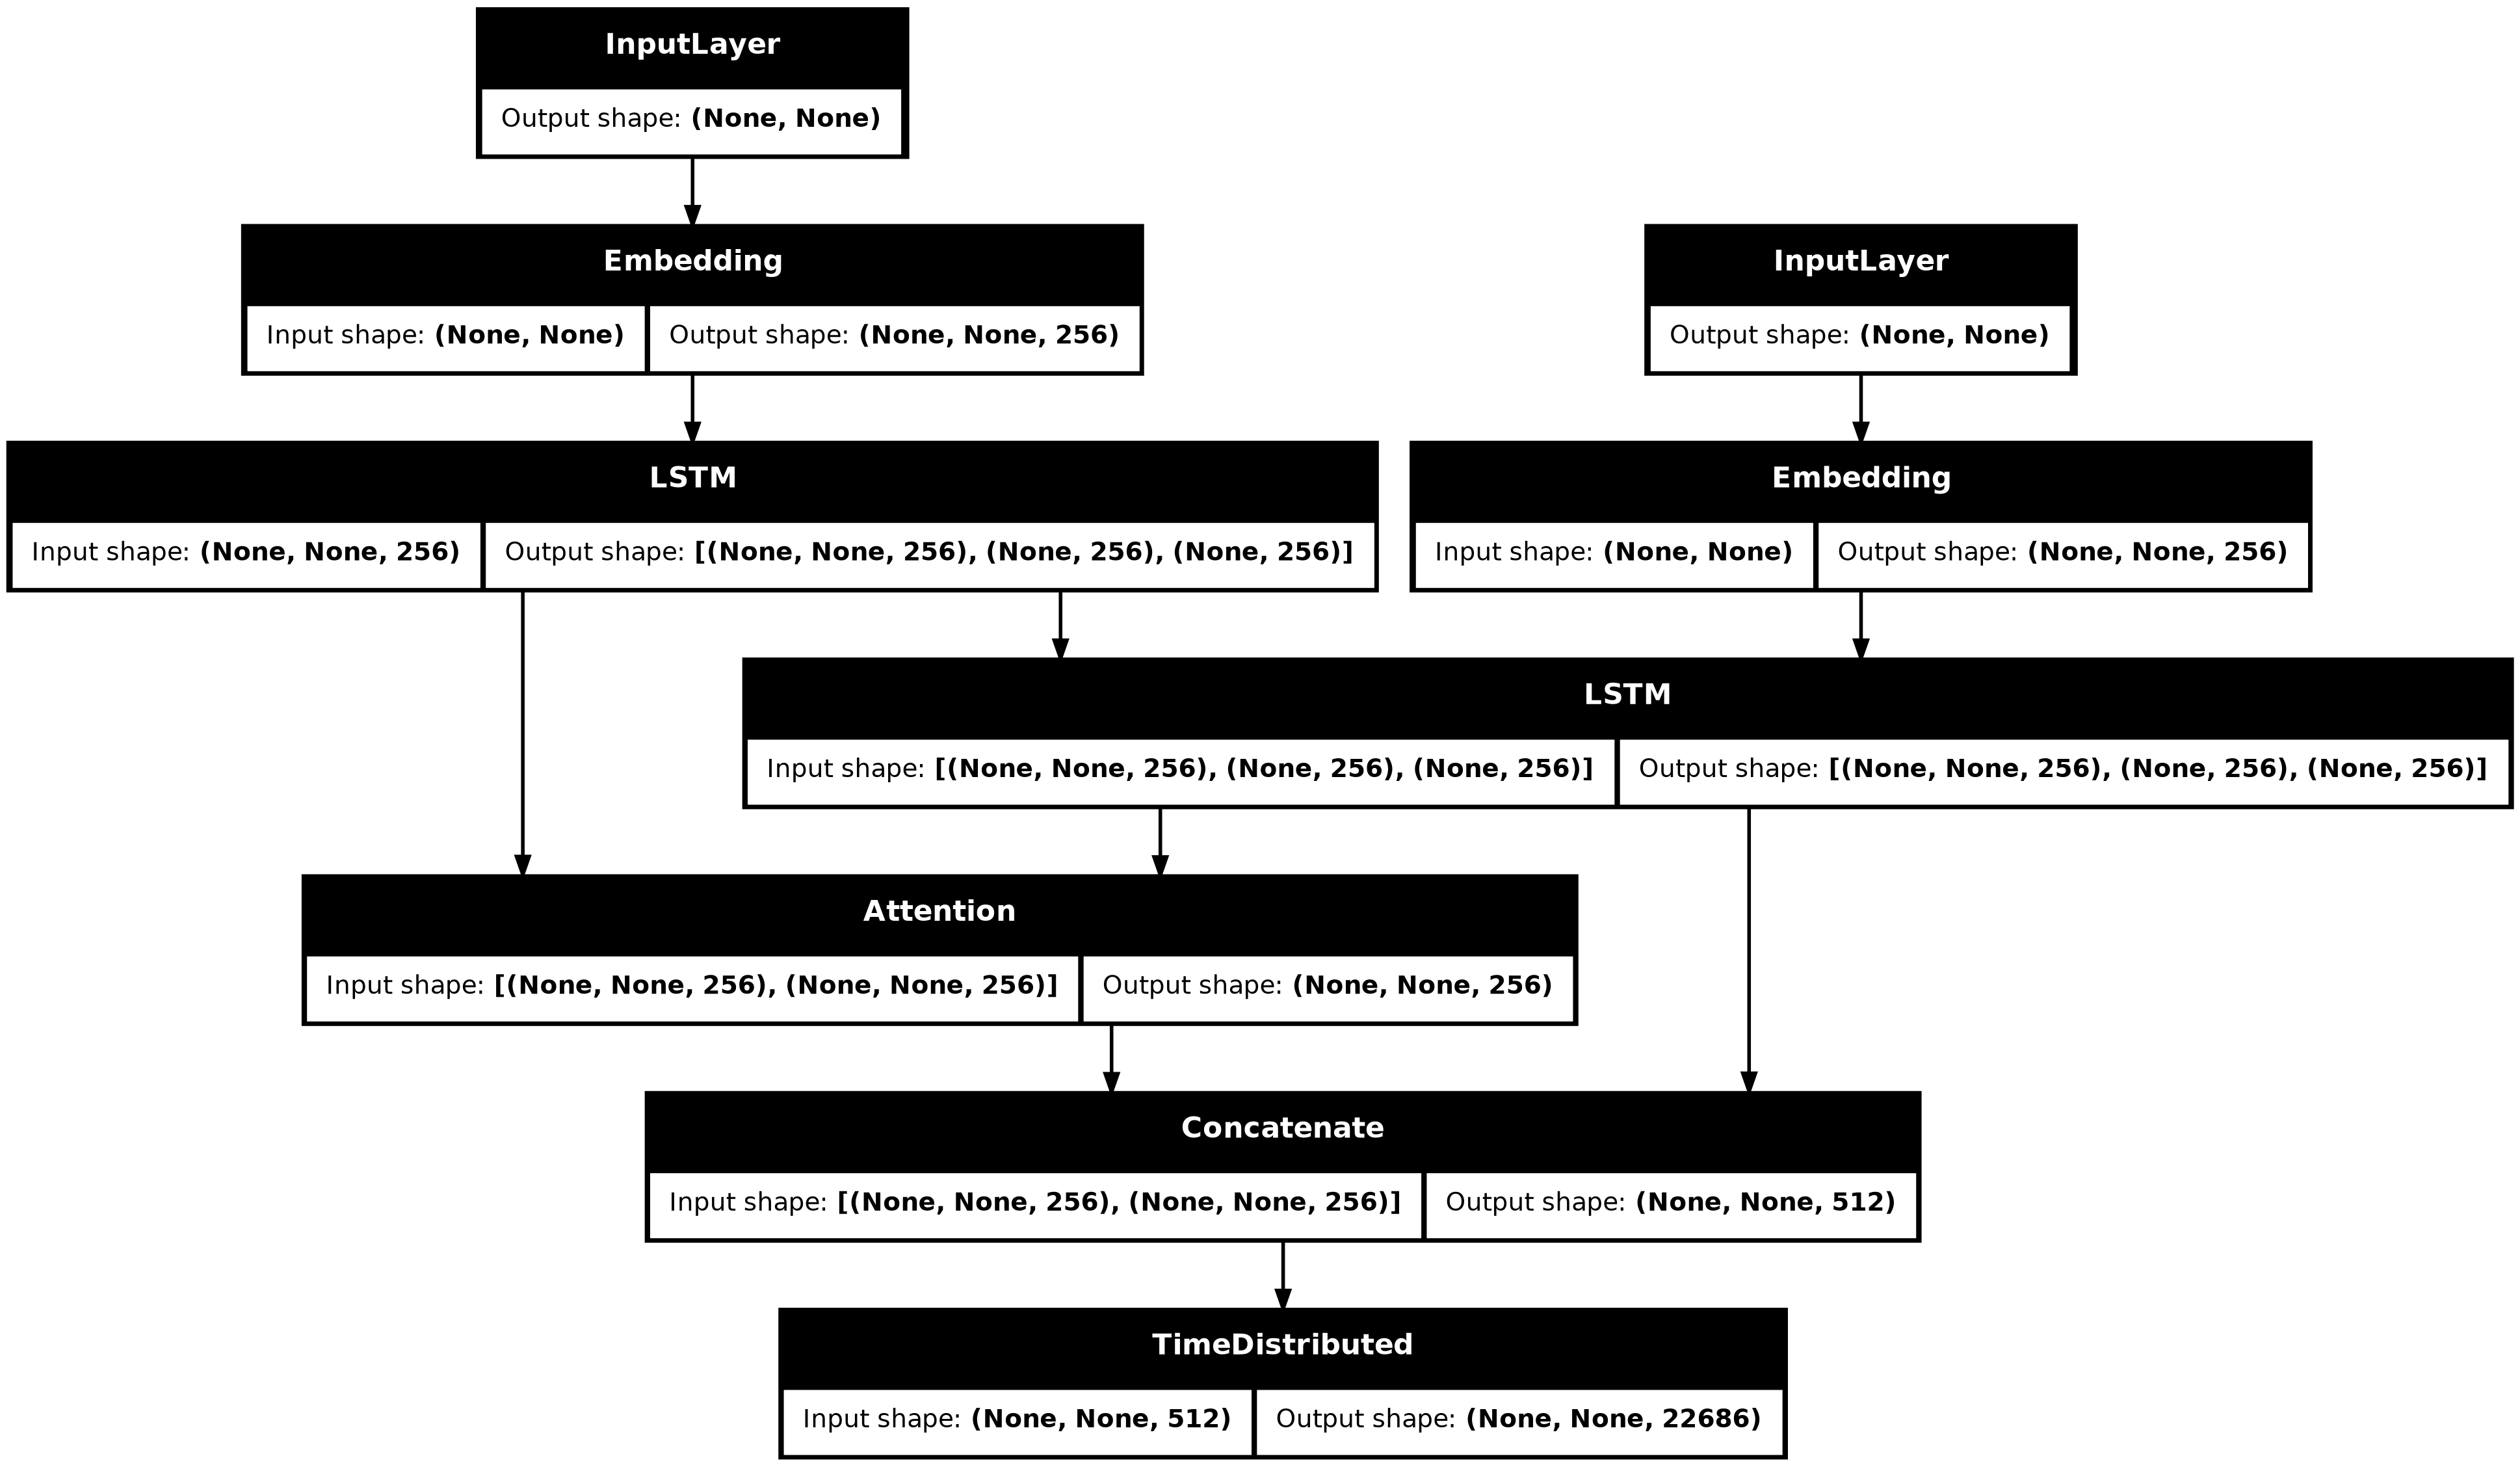

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
model.fit([x_train, y_train[:, :-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:], epochs=50, batch_size=64, validation_data=([x_test, y_test[:, :-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:, 1:]))

Epoch 1/50


2024-07-16 16:29:26.307388: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  39/1488 ━━━━━━━━━━━━━━━━━━━━ 8:32 354ms/step - accuracy: 0.7513 - loss: 5.3450

KeyboardInterrupt: 

In [ ]:
model.save('seq2seq.h5')
with open('tokenizer_x.pkl', 'wb') as f:
    pkl.dump(tokenizer_x, f)
with open('tokenizer_y.pkl', 'wb') as f:
    pkl.dump(tokenizer_y, f)